In [ ]:
! pip install tflite-model-maker

In [5]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

TensorFlow Version: 2.5.0
Model Maker Version: 0.3.2


In [3]:
!nvidia-smi

Wed Jun 16 15:10:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# Download folder and unzip it
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182083584/182082353 [==============================] - 2s 0us/step


## Training the Model

When using Model Maker for audio, you have to start with a model spec. This is the base model that your new model will extract information to learn about the new classes. It also affects how the dataset will be transformed to respect the models spec parameters like: sample rate, number of channels.

[YAMNet](https://tfhub.dev/google/yamnet/1) is an audio event classifier trained on the AudioSet dataset to predict audio events from the AudioSet ontology.

It's input is expected to be at 16kHz and with 1 channel.

You don't need to do any resampling yourself. Model Maker takes care of that for you.

- `frame_length` is to decide how long each traininng sample is. in this case EXPECTED_WAVEFORM_LENGTH * 1s

- `frame_steps` is to decide how far appart are the training samples. In this case, the ith sample will start at EXPECTED_WAVEFORM_LENGTH * 1s after the (i-1)th sample.

The reason to set these values is to work around some limitation in real world dataset.

For example, in the bird dataset, birds don't sing all the time. They sing, rest and sing again, with noises in between. Having a long frame would help capture the singing, but setting it too long will reduce the number of samples for training.


In [7]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=True,
    frame_step=1 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH // 2,
    frame_length=1 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

INFO:tensorflow:Checkpoints are stored in /tmp/tmp3aej0_jj


In [8]:
train_data = audio_classifier.DataLoader.from_folder(spec, data_dir, cache=True)
train_data, validation_data = train_data.split(0.8)

In [24]:
print(type(train_data))
print(len(train_data))
print(train_data.gen_dataset().take(1))

for i in train_data.gen_dataset().take(1):
  print(i)

<class 'tensorflow_examples.lite.model_maker.core.data_util.audio_dataloader.DataLoader'>
6400
<TakeDataset shapes: ((None, 1024), (None, 8)), types: (tf.float32, tf.float32)>
(<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
array([[0.        , 0.00478534, 0.05378029, ..., 0.21486197, 0.        ,
        0.        ]], dtype=float32)>, <tf.Tensor: shape=(1, 8), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)>)


## Training the model

the audio_classifier has the [`create`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/create) method that creates a model and already start training it. 

You can customize many parameterss, for more information you can read more details in the documentation.

On this first try you'll use all the default configurations and train for 100 epochs.

Note: The first epoch takes longer than all the other ones because it's when the cache is created. After that each epoch takes close to 1 second.

In [17]:
batch_size = 32
epochs = 40

print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=batch_size,
    epochs=epochs)

Training the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
classification_head (Dense)  (None, 8)                 8200      
Total params: 8,200
Trainable params: 8,200
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
183/183 [==============================] - 89s 463ms/step - loss: 2.0443 - acc: 0.2021 - val_loss: 1.9202 - val_acc: 0.3054
Epoch 2/40
183/183 [==============================] - 1s 7ms/step - loss: 1.9024 - acc: 0.2930 - val_loss: 1.8355 - val_acc: 0.3626
Epoch 3/40
183/183 [==============================] - 1s 7ms/step - loss: 1.8412 - acc: 0.3188 - val_loss: 1.7895 - val_acc: 0.3823
Epoch 4/40
183/183 [==============================] - 1s 8ms/step - loss: 1.7975 - acc: 0.3374 - val_loss: 1.7527 - val_acc: 0.3952
Epoch 5/40
183/183 [==============================] - 1s 7ms/step - loss: 1.7603 - acc: 0.3537 - v

In [19]:
print('Evaluating the model')
model.evaluate(validation_data)

Evaluating the model
46/46 [==============================] - 17s 342ms/step - loss: 1.5401 - acc: 0.4769


[1.540062427520752, 0.47687074542045593]

## Understanding your model

When training a classifier, it's useful to see the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The confusion matrix gives you detailed knowledge of how your classifier is performing on test data.

Model Maker already creates the confusion matrix for you.

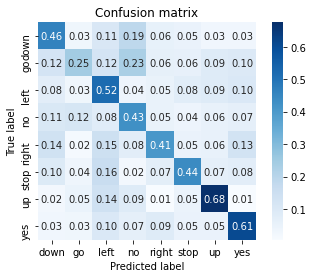

In [23]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(validation_data)
show_confusion_matrix(confusion_matrix.numpy(), validation_data.index_to_label)

In [25]:
serving_model = model.create_serving_model()

print(f'Model\'s input shape and type: {serving_model.inputs}')
print(f'Model\'s output shape and type: {serving_model.outputs}')

Model's input shape and type: [<KerasTensor: shape=(None, 15600) dtype=float32 (created by layer 'audio')>]
Model's output shape and type: [<KerasTensor: shape=(1, 521) dtype=float32 (created by layer 'keras_layer')>, <KerasTensor: shape=(1, 8) dtype=float32 (created by layer 'sequential')>]


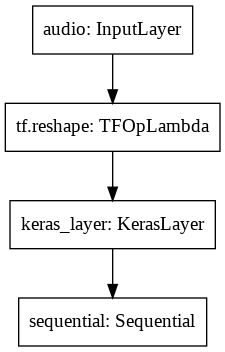

In [26]:
tf.keras.utils.plot_model(serving_model)

In [27]:
serving_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
audio (InputLayer)           [(None, 15600)]           0         
_________________________________________________________________
tf.reshape (TFOpLambda)      (15600,)                  0         
_________________________________________________________________
keras_layer (KerasLayer)     [(1, 521), (1, 1024), (96 0         
_________________________________________________________________
sequential (Sequential)      (None, 8)                 8200      
Total params: 8,200
Trainable params: 8,200
Non-trainable params: 0
_________________________________________________________________


In [28]:
saved_model_path = './yamnet_model_maker'
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./yamnet_model_maker/assets


INFO:tensorflow:Assets written to: ./yamnet_model_maker/assets


In [29]:
# Use with TF 2.5.0 no quantization
MODEL_PATH  = saved_model_path
MODEL_SAVE_PATH = "/content/yamnet_speech_commands.tflite"
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_PATH) #,signature_keys=['serving_default'])
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.experimental_new_converter = True
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

tflite_model = converter.convert()
with tf.io.gfile.GFile(MODEL_SAVE_PATH, 'wb') as f:
  f.write(tflite_model)


# OR 
'''
models_path = '/content/yamnet_speech_commands'
print(f'Exporing the TFLite model to {models_path}')

model.export(models_path, tflite_filename='yamnet_speech_commands.tflite')
'''